# 打开股票量化的黑箱(自己动手实现一个印钞机) 第二章

### 作者：阿布🐶

### 未经本人允许禁止转载

##  非均衡胜负收益带来的必然非均衡胜负比例，目标由因子的能力解决一部分，模式识别提升关键的一部分


### 非均衡胜负收益是什么意思？
### 文言文这就是😄，意思简单说就是每次赢的钱比每次输的钱多

### 为什么这是穿行的第一步呢，因为在股票交易者，交易者永远是处于不利的地位的，不利的情况就是你
### 的交手续费，你可能会说那个没有多少钱，如果你随机的胡乱买卖股票，在你有足够多的本钱的情况下
### 交易足够多的次数，最后的结果一定是符合正太分布的，但是如果你没次要多交你1%的手续费，情况就
### 大不一样了，赌场要抽头，不抽头的赌场一定是老千,  要吃人的赌场又抽头又出老千 'a股' 😄

下面用代码描述这几种情况

In [40]:
import ZEnv
import ZLog
import ZCommonUtil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numba as nb

%matplotlib inline

In [43]:
"""
    设置100个赌徒
"""
gamblers = 100

"""
    赌场：简单设定每个赌徒一共有1000000一共想在赌场玩10000000次，你要是没钱了也别想玩了
    win_rate:   输赢的概率
    win_once:   没次赢的钱数
    loss_once:  没次输的钱数
    commission: 手续费这里简单的设置了0.01 1%
"""
def casino(win_rate, win_once=1, loss_once=1, commission=0.01):
    my_money = 1000000
    play_cnt = 10000000
    commission = commission
    for _ in np.arange(0, play_cnt):
        w = np.random.binomial(1, win_rate)
        if w:
            my_money += win_once
        else:
            my_money -= loss_once
        my_money -= commission
        if my_money <= 0:
            break
    return my_money

"""
    使用numba预编译加速，否则很慢
"""
casino_nb = nb.jit(casino)

"""
    天堂赌场，没有抽头，没有老千😇
    heaven_moneys 100个
    都去了之后玩回来之后的结果
"""
heaven_moneys = [casino_nb(0.5, commission=0) for _ in np.arange(0, gamblers)]

"""
    没有抽头，有老千😫
"""
moneys_low = [casino_nb(0.4, commission=0) for _ in np.arange(0, gamblers)]

"""
    有抽头，没有老千😫
"""
moneys_commission = [casino_nb(0.5, commission=0.01) for _ in np.arange(0, gamblers)]

"""
    有抽头，有老千😫
"""
moneys_low_commission = [casino_nb(0.4, commission=0.01) for _ in np.arange(0, gamblers)]

### 1. 天堂赌场，大家都能活下来，每个人亏的和赚的最后都不太多

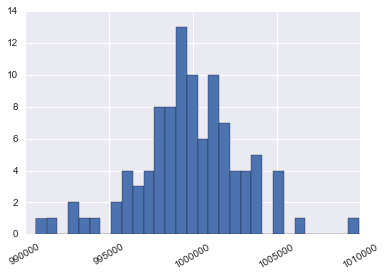

In [44]:
plt.setp(plt.gca().get_xticklabels(), rotation=30)
pd.Series(heaven_moneys).hist(bins=30)

### 2. 有老千的赌场没有人能活下来，钱都归零了

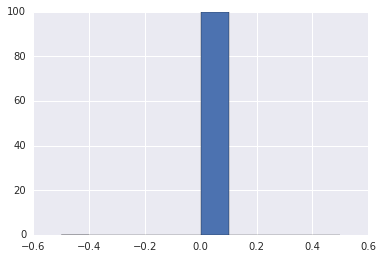

In [40]:
pd.Series(moneys_low).hist()

### 3. 有抽头的赌场，看起来还不错，但是没有一个人赚钱的都是亏钱，当玩的次数再加大一个数量级，最后的结果也一定是归0

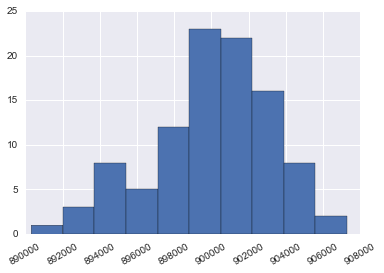

In [45]:
plt.setp(plt.gca().get_xticklabels(), rotation=30)
pd.Series(moneys_commission).hist()

In [44]:
help(casino)

Help on function casino in module __main__:

casino(win_rate, win_once=1, loss_once=1, commission=0.01)



### 假设我们的赌场没有老千，但是一定会有手续费，这样的话注意上面的赌场函数，我们不能期待我们有老千能力，也就是比如说你能有内部消息，把胜率提高到60%或者更高，如果你真的有，那么土豪我们做朋友吧👻加微信一起发财,  那就只有每次赢钱和每次输钱的参数了

In [46]:
moneys = [casino_nb(0.5, commission=0.01, win_once=1.02, loss_once=0.98) for _ in np.arange(0, gamblers)]

### 和上面那个直方图📊对比你能发现每个人都能赢钱了，当我们设置了每次赢多出默认两个点，每次输少输两个点后

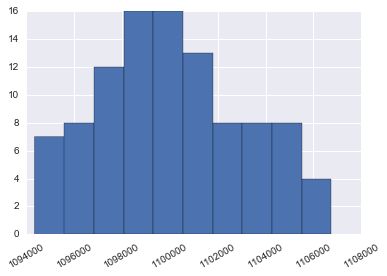

In [47]:
plt.setp(plt.gca().get_xticklabels(), rotation=30)
pd.Series(moneys).hist()

### 但是这样的话问题就来了，你凭什么能每次多赢，每次少输，其实很简单，每本关于股票的书籍都会提到止损的策略

### 这些策略的核心思想就是让赚钱股票的多赚钱，让亏损股票的少亏损(他们的文言文写的就是什么让利润奔跑✈️)这样的结果就是亏损的次数比赢钱的次数多，每次赢的钱比每次亏的钱多, 也就是高止盈位，低止损位

### 所以你发现了吗，不能平白无故的提高win_once, 对应的要降低win_rate，这是自己给自己摆千的节奏啊，所以win_rate可能是0.45甚至更低

In [49]:
moneys = [casino_nb(0.45, commission=0.01, win_once=1.02, loss_once=0.98) for _ in np.arange(0, gamblers)]

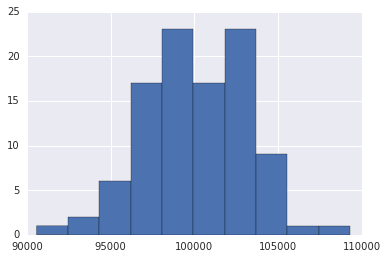

In [50]:
pd.Series(moneys).hist()

看到这个图了吧，最后的结果就是又回到了有输有赢的人，这就是文章主题提到的:
    
## ‘非均衡胜负收益’带来的必然’非均衡胜负比例‘

上文提到了要实现 **非均衡胜负收益**, 怎么才能做到这个呢，试着把你的止盈位提高，降低你的止损位，比如说
你10块钱买入一个股票， 止盈15止损9块就附和目标，这样你能理解带来的必然’非均衡胜负比例‘这个意思了吧。

但是这个止盈止损位合理吗，是不是应该调到14， 8呢或者20，9呢，这个就是量化系统所做的一般任务，记得上一章说的alpha
beta，facotr的职能和任务吗，他们的任务就是在因子的上层控制止盈止损，因子自己也会有自己的止盈止损位。

### 量化系统的一大部分功用就是维持这个‘非均衡胜负收益’ ’非均衡胜负比例‘的交易系统能活下来，生存是第一需求，他们的目标就是生存
### 其实说的一点也不夸张，虽然alpha是激进的但它的激进只是为了与保守的beta一起能活下去，我们的系统要挣钱就要依靠因子的能力，因子的能力主要功用就是尽量平衡‘非均衡胜负收益’ 与 ’非均衡胜负比例‘需找最优点，活下来，并且能活得挺好。

### 因子有各种各样的方式去强化能力，需找最优，提高胜率，由于这篇文章的重点不是如何提高因子的能力，那个主题其实你也可以在其它一些量化分章中找到一些方法，下面只简单介绍一个实例，希望你能理解

## 目标由’因子‘的能力解决一部分

### 下面讲一个实例如何来提高因子的能力

上一章结尾简单介绍过黄金分割因子，这里使用它作为因子，再次详细说明一下

In [26]:
import SymbolPd
import TLineGolden
# 选择一段符合买入条件的位置
kl_pd = SymbolPd.make_kfold_pd('usNOAH')[-82:-40]

如下图所示，这里选择了[-82:-40] 42天数据模拟，且这一天符合买入条件，这个条件你可以认为是
1. 在blow382和above382之间
2. ma5 > ma10
3. 大盘。。。
4. 。。。。

**我就不叙述了，因子的规则有各种，变种也各异，没有必要赘述**

mc_percent_default是默认的止盈止损位队列，mc_percent是经过最优计算出的我们会使用的
止盈止损位队列，一会我们的主要任务就是演示怎么算出来的这个

In [34]:
# 各个止盈止损默认点，就如下图命中所示标准的200，250，300
mc_percent_default = [0.200, 0.250, 0.300, 0.382,
                0.618, 0.700, 0.800, 0.900, 0.950]


# 但我们不用上面那个默认的，为什么，因为那个的效果没下面这个好
mc_percent = [0.21828571428571428, 0.27285714285714285, 0.3274285714285714, 0.382,
              0.7271428571428571, 0.7817142857142857, 0.8362857142857143, 0.8908571428571428, 0.9454285714285714]

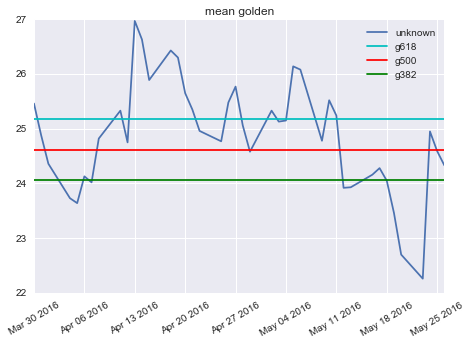

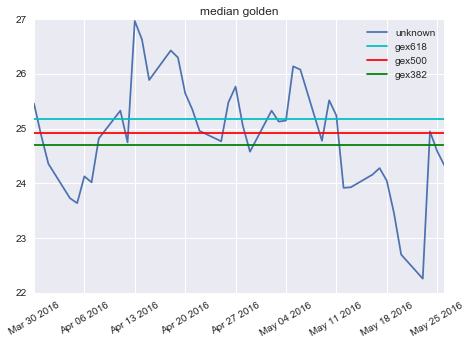

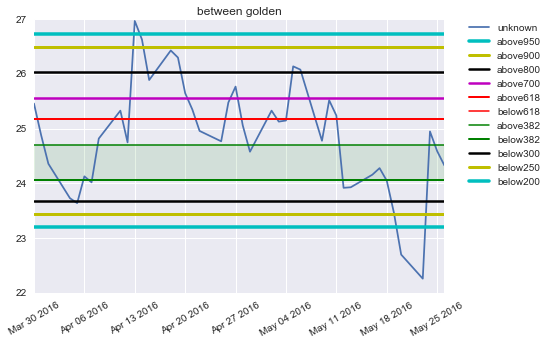

golden(g382=24.05922, gex382=24.695920000000001, g500=24.615000000000002, gex500=24.914999999999999, g618=25.170780000000001, gex618=25.180419999999998, above618=25.180419999999998, below618=25.170780000000001, above382=24.695920000000001, below382=24.05922, above950=26.734499999999997, above900=26.498999999999999, above800=26.027999999999999, above700=25.556999999999999, below300=23.673000000000002, below250=23.4375, below200=23.202000000000002)

In [28]:
TLineGolden.calc_golden(kl_pd)

### 弹力止盈止损
上一节说过使用弹力止盈止损，如果股价下跌到below200我的最高止盈
也随着下降一个档，如果股价上升一个档，最低止损也上升一个档位，直至
向上或者向下击穿止最后一个盈止损位，这里简单用代码演示一下，只是演示！
实际运行会复杂很多，因为有alpha，beta，因子本身及，因子的父类等各种
诱因，这里只单纯演示弹力止盈止损！

### 如下所示int_demo_trade 模拟初始24.16买入，通过买入价格初始化，初始化各个止盈止损价格，注意这里说的是价格，止盈止损位已经定义好了就是mc_percent，通过mc_percent和买入价确定了各个止盈止损价格，demo_trade模拟交易这里演示了弹力止盈止损是如何运作的。do_cnt_demo_trade封装一次交易

In [37]:
import WinLossAlloc
def int_demo_trade():
    # 假设以24.16买入，初始化，支撑阻力位
    bid_price = 24.16
    
    # 注意这里切分9个位，指定止损位是4个，那么止盈位就是5个了
    # 目的就是非均衡胜负与非均衡胜负比例的环境形成
    loss_cnt = 4
    golden = TLineGolden.calc_mc_golden(kl_pd, mc_percent, loss_cnt)
    
    wl = WinLossAlloc.init_golden_w_full(golden, bid_price)
    # 形成所以阻力有支撑，完整的弹力止盈止损位到齐
    print 'init supports : {}'.format(sorted(wl['supports'])), \
          'init resistances : {}'.format(sorted(wl['resistances']))
    # print('\n')
    return wl

def demo_trade(wl):
    result_price = 0
    rs_cnt = 0
    while wl is not None:
        rs_cnt += 1
        supports = wl['supports']
        resistances = wl['resistances']
        # 45%概率win
        win = np.random.binomial(1, 0.45)
        if win:
            result_price = resistances[-1]
        else:
            result_price = supports[0]

        # 将输赢做为参数，重新计算出止盈止损位
        wl = WinLossAlloc.golden_map_wl_grid(win, wl)
        
        win_str = 'win' if win else 'loss'
        
        print(format('*', '*^108s'))
        print '{} result is {}'.format(rs_cnt, win_str)
        if wl:
            print 'supports : {}'.format(sorted(wl['supports'])), \
                  'resistances : {}'.format(sorted(wl['resistances']))
                  
    
    bid_price = 24.16
    print 'result profit is {}'.format((result_price - bid_price))
    print(format('©', '*^108s'))
    print('\n')
    
def do_cnt_demo_trade(t_cnt):
    while t_cnt > 0:
        wl = int_demo_trade()
        demo_trade(wl)
        t_cnt -= 1

In [39]:
# 模拟运行10次交易，通过输出是否看懂了什么是弹力止盈止损了呢
# 请尽量理解这里，不然继续向下不容易理解
do_cnt_demo_trade(10)

init supports : [23.288125714285716, 23.545157142857143, 23.802188571428573, 24.05922] init resistances : [25.684842857142858, 25.941874285714285, 26.198905714285715, 26.455937142857142, 26.712968571428569]
************************************************************************************************************
1 result is win
supports : [23.545157142857143, 23.802188571428573, 24.05922, 25.684842857142858] resistances : [25.941874285714285, 26.198905714285715, 26.455937142857142, 26.712968571428569]
************************************************************************************************************
2 result is win
supports : [24.05922, 25.684842857142858, 25.941874285714285] resistances : [26.198905714285715, 26.455937142857142, 26.712968571428569]
************************************************************************************************************
3 result is win
supports : [25.941874285714285, 26.198905714285715] resistances : [26.455937142857142, 26.71296857142856

**相信你看了代码和输出后就能理解弹力止盈止损位了**

### 上面的实现是使用mc_percent = [0.21828571428571428, 0.27285714285714285, 0.3274285714285714, 0.382, 0.7271428571428571, 0.7817142857142857, 0.8362857142857143, 0.8908571428571428, 0.9454285714285714]我们说效果好，怎么定义效果好呢？答案就是运行了多次之后，结果结果最好，听起来是不是好傻，但是其实不管数学上名字叫的多吓唬人，公式看起来有多复杂，这种思想都是基础，蒙特卡洛就是这种的典型应用，凸优化其实也是，只不过它有计算梯度的方式，加快速度，但是这样你就很有可能陷入局部最优，一般就是先大概结出全局最优，然后带入求局部最优。

### 接下来我们用默认的就是mc_percent_default = [0.200, 0.250, 0.300, 0.382, 0.618, 0.700, 0.800, 0.900, 0.950]执行20000次，看看使用默认的值，多次之后输出的结果！

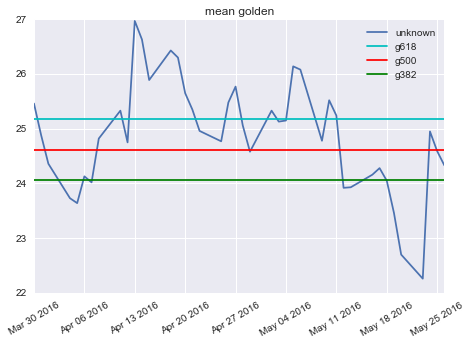

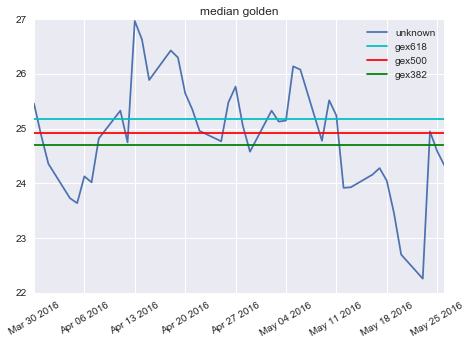

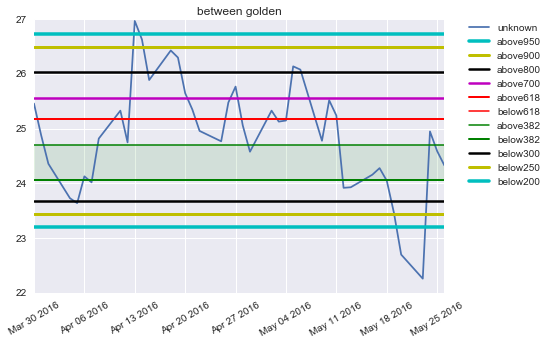

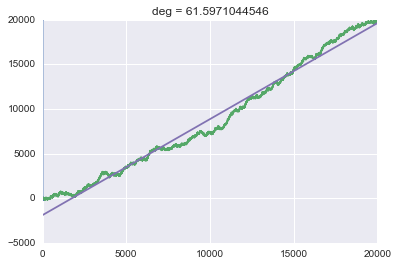

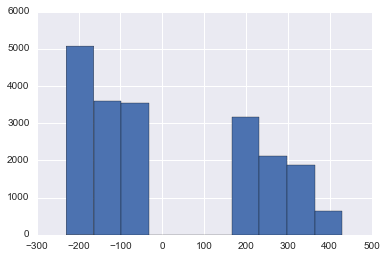

In [3]:
WinLossAlloc.show_golden_process(0.42, bp=24.3, pf_cnt=200, loop_cnt=20000)

执行弹力位止盈止损，0.42作为win_rate 第四个代表收益曲线，第五图代表在这些止盈止损位上的收益分布

上面的操作, **量化了**mc_percent_default = [0.200, 0.250, 0.300, 0.382, 0.618, 0.700, 0.800, 0.900, 0.950]总公的收益是多少, 上升趋势是否平稳，收益分布是否合理，这样我们就有了一个评判mc_percent参数的量化准则了，下面开始寻找最优参数

**使用蒙特卡洛方法分析最优**

1. 输赢比例
2. 输赢资金的比例
3. 最后总收益

很明显受益的关键是输赢资金的比例，所以思路最优输赢资金的比例

* n_jobs=-1 使用并行加速
* 所有函数名称带nb的使用numba做编译加速处理，但效果一般，且使用numba会有一些限制条件

In [57]:
filter(lambda func: func.startswith('show_golden'), dir(WinLossAlloc)) 

['show_golden_mc_nb_process',
 'show_golden_mc_nb_product_process',
 'show_golden_mc_process',
 'show_golden_mc_product_process',
 'show_golden_nb_process',
 'show_golden_process',
 'show_golden_sco_process']

In [23]:
# 部分代码，详细代码请查询WinLossAlloc源代码
def show_golden_mc_product_process(w_rate, n_jobs=1, symbol=None, max_iter=8, bp=24.3, pf_cnt=200, loop_cnt=20000,
                                   p_outter_loop=1):
    """
    使用模特卡洛方式分析寻找最优参数, 排列最合所有元素
    :param n_jobs:
    :param w_rate:
    :param symbol:
    :param max_iter:
    :param bp:
    :param pf_cnt:
    :param loop_cnt:
    :param p_outter_loop:
    :return:
    """

    """
        ⚠️控制max_iter, 15以上就会有上亿种排列组合了
    """
    loss_percents = np.linspace(0.0, 0.382, max_iter)
    win_percents = np.linspace(0.618, 1.0, max_iter)
    ls = list(itertools.combinations(loss_percents, g_mc_loss_cnt))
    ws = list(itertools.combinations(win_percents, g_mc_win_cnt))
    lws = list(itertools.product(ls, ws))

    # 暂时默认8核cpu,且把0及其它都归结为-1的范畴
    n_jobs = 8 if n_jobs <= 0 else n_jobs
    process_lws = []
    if n_jobs > 1:
        group_adjacent = lambda a, k: zip(*([iter(a)] * k))
        process_lws = group_adjacent(lws, n_jobs)
        # 将剩下的再放进去
        sf = -(len(lws) % n_jobs)
        if sf < 0:
            process_lws.append(lws[sf:])
    else:
        process_lws.append(lws)

    parallel = Parallel(
        n_jobs=n_jobs, verbose=0, pre_dispatch='2*n_jobs')

    out = parallel(
        delayed(_do_mc_product_process)(sub_lws, w_rate, symbol, bp, pf_cnt, loop_cnt,
                                        p_outter_loop)
        for sub_lws in process_lws)

    profits_dict = {}
    for sub_profits_dict in out:
        profits_dict.update(sub_profits_dict)

    return _golden_mc_process_profits(profits_dict)

def show_golden_mc_process(w_rate, symbol=None, max_iter=5000, bp=24.3, pf_cnt=200, loop_cnt=20000, p_outter_loop=1):
    """
    使用模特卡洛方式分析寻找最优参数
    :param w_rate:
    :param symbol:
    :param max_iter:
    :param bp:
    :param pf_cnt:
    :param loop_cnt:
    :param p_outter_loop:
    :return:
    """
    profits_dict = {}
    loss_percents = np.linspace(0.0, 0.382, 100)
    win_percents = np.linspace(0.618, 1.0, 100)
    golden_tuple = namedtuple('golden', (
        'below200', 'below250', 'below300', 'below382', 'above618', 'above700', 'above800', 'above900', 'above950'))

    if symbol is None:
        kl_pd = SymbolPd.make_kfold_pd('usNOAH')[-82:-40]
    else:
        kl_pd = SymbolPd.make_kfold_pd(symbol)

    for _ in np.arange(max_iter):
        loss_percent = np.random.choice(loss_percents, g_mc_loss_cnt, replace=False)
        win_percent = np.random.choice(win_percents, g_mc_win_cnt, replace=False)

        _golden_mc_process_cmp(kl_pd, loss_percent, win_percent, golden_tuple, profits_dict, w_rate,
                               bp, pf_cnt, p_outter_loop, loop_cnt, show=False)
    return _golden_mc_process_profits(profits_dict)


### 假设能达到0.42的胜率，这个0.42不代表最终能获胜的比例，只是每一次的胜率，可以认为这个值可以更高到0.5，最终的胜率由于高止盈位，低止损位会低于这个值，胜率其实在这个策略里是由各个止损止盈位决定的，这里是固定了这个参数，然后运用蒙特卡洛数学方法，这里是运用切片可能性然后排列最合所有元素,  首先可视化结果, 可以清楚的看出，要想最终能赢钱，关键点就是输赢钱的比例，每次赢的钱比输的钱越多，才有可能达到最后盈利（越向右红色的球越多，图例显示红球能够盈利）

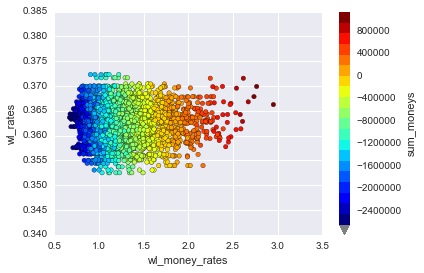

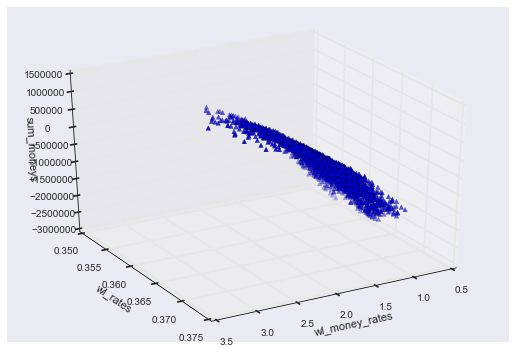

CPU times: user 20.4 s, sys: 1.27 s, total: 21.7 s
Wall time: 11min 44s


,wl_money_rates,wl_rates,sum_moneys,keys
0,0.888262,0.3637,-1.65208e+06,"[0.0, 0.05457142857142857, 0.1637142857142857,..."
1,1.00664,0.36365,-1.45369e+06,"[0.05457142857142857, 0.10914285714285714, 0.1..."
2,1.20171,0.3639,-959044,"[0.05457142857142857, 0.10914285714285714, 0.2..."
3,2.0125,0.3665,287482,"[0.1637142857142857, 0.27285714285714285, 0.32..."
4,1.76614,0.3649,39940.5,"[0.05457142857142857, 0.1637142857142857, 0.27..."
5,1.11732,0.36155,-1.2195e+06,"[0.0, 0.05457142857142857, 0.1637142857142857,..."
6,0.781668,0.3563,-2.11277e+06,"[0.0, 0.05457142857142857, 0.10914285714285714..."
7,0.803086,0.365,-2.18998e+06,"[0.0, 0.05457142857142857, 0.10914285714285714..."
8,0.96974,0.3676,-1.45295e+06,"[0.0, 0.10914285714285714, 0.21828571428571428..."
9,2.41752,0.35775,694218,"[0.05457142857142857, 0.27285714285714285, 0.3..."


In [4]:
%time wl_pd = WinLossAlloc.show_golden_mc_product_process(0.42, n_jobs=-1)
wl_pd

简单分析一下结果

In [7]:
wl_pd['sum_moneys'].mean(), wl_pd['wl_rates'].mean(), wl_pd['wl_money_rates'].mean()

(-868311.44464704266, 0.36232785714285981, 1.2840789250773326)

In [8]:
pd.qcut(wl_pd['wl_money_rates'], 100).value_counts().head()

(2.262, 2.952]    40
(1.505, 1.516]    40
(0.853, 0.868]    40
(0.917, 0.928]    40
(0.965, 0.975]    40
Name: wl_money_rates, dtype: int64

In [9]:
pd.qcut(wl_pd['sum_moneys'], 10).value_counts()

(-36011.0789, 1145831.81]        392
(-312159.593, -36011.0789]       392
(-519729.523, -312159.593]       392
(-696741.476, -519729.523]       392
(-869575.307, -696741.476]       392
(-1034834.848, -869575.307]      392
(-1211503.0155, -1034834.848]    392
(-1416435.858, -1211503.0155]    392
(-1706524.702, -1416435.858]     392
[-2629618.186, -1706524.702]     392
Name: sum_moneys, dtype: int64

还可以使用凸优化求解最优方程方法：详细代码请查询WinLossAlloc 

            bnds = list((0, 0.382) for _ in range(g_mc_loss_cnt)) + list((0.618, 1) for _ in range(g_mc_win_cnt))
            opts = sco.minimize(min_func_st(how), guess_loss_precent + guess_win_precent, method='SLSQP',
                                bounds=bnds, options={'maxiter': max_iter})
                                
            问题是容易陷入局部最优，且不要太精度，可以先求全局最优在局部

In [11]:
opts, min_func = WinLossAlloc.show_golden_sco_process(0.42, how='sum_money')
ZLog.info(opts)
x_array = sorted(opts['x'])
ZLog.info(x_array)
min_func(x_array)

     fun: 174767.91599998067
     jac: array([ -3.12758046e+11,   1.14246519e+12,   4.51745309e+12,
         1.48845611e+12,   6.39651998e+12,   3.96886976e+12,
         3.69526407e+12,   6.19485965e+12,   7.27680427e+11,
         0.00000000e+00])
 message: 'Inequality constraints incompatible'
    nfev: 11
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([ 0.382     ,  0.32742857,  0.16371429,  0.05457143,  1.        ,
        0.78171429,  0.89085714,  0.618     ,  0.94542857])
[0.054571428571428569, 0.1637142857142857, 0.3274285714285714, 0.38200000000000001, 0.61799999999999999, 0.78171428571428569, 0.89085714285714279, 0.9454285714285714, 1.0]


array([  1.63884331e+00,   3.61100000e-01,  -1.76024719e+05])

**下一步从mc 最优结果里筛选, 或者使用全局最优brust求解**
        
从图分析，限制条件，找到n个解

In [13]:
filter_pd = wl_pd[(wl_pd['wl_money_rates'] > 2.5) & (wl_pd['wl_rates'] > 0.36)]
filter_pd

,wl_money_rates,wl_rates,sum_moneys,keys
18,2.60605,0.36285,848494,"[0.1637142857142857, 0.27285714285714285, 0.32..."
83,2.53842,0.36955,792692,"[0.21828571428571428, 0.27285714285714285, 0.3..."
825,2.73422,0.36785,1.03147e+06,"[0.1637142857142857, 0.27285714285714285, 0.32..."
992,2.76393,0.3699,1.01709e+06,"[0.21828571428571428, 0.27285714285714285, 0.3..."
1150,2.53375,0.3612,710380,"[0.21828571428571428, 0.27285714285714285, 0.3..."
1470,2.67015,0.3668,887030,"[0.21828571428571428, 0.27285714285714285, 0.3..."
1573,2.58725,0.36135,760860,"[0.21828571428571428, 0.27285714285714285, 0.3..."
1632,2.61526,0.37155,883938,"[0.21828571428571428, 0.27285714285714285, 0.3..."
2280,2.52984,0.3646,734905,"[0.21828571428571428, 0.27285714285714285, 0.3..."
3288,2.95173,0.36625,1.14583e+06,"[0.21828571428571428, 0.27285714285714285, 0.3..."


**可视化人工从这n个里挑选最合适的**

柱状要分布均匀，且达成非均衡
这里选择第四个（992），阻力支撑保持非均衡，且200-500全分部，下降均匀

In [ ]:
WinLossAlloc.check_golden_mc_result(filter_pd, 0.42)

这里人工选择了第四个结果

    [0.21828571428571428, 0.27285714285714285, 0.3274285714285714, 0.382, 0.7271428571428571, 0.7817142857142857, 0.8362857142857143, 0.8908571428571428, 0.9454285714285714]
    
作为弹力止盈止损位，这个就是这里演示的优化因子的能力的一部分，还有很多因子能力得到优化的地方，比如使用grid search选择合适的因子参数等等，这篇文章的重点不在因子能力的提升，如有问题私下沟通我，模式识别将是文章的重点

In [16]:
filter_pd.iloc[3], filter_pd.iloc[3]['keys']

(wl_money_rates                                              2.53375
 wl_rates                                                     0.3612
 sum_moneys                                                   710380
 keys              [0.21828571428571428, 0.27285714285714285, 0.3...
 Name: 1150, dtype: object,
 '[0.21828571428571428, 0.27285714285714285, 0.3274285714285714, 0.382, 0.7271428571428571, 0.7817142857142857, 0.8362857142857143, 0.8908571428571428, 0.9454285714285714]')

_______

## 因子的能力度量(选读与文章主题关系不大，下一章开始才能进入正题😓)

**‘非均衡胜负收益’带来的必然’非均衡胜负比例‘，目标由’因子‘的能力解决一部分**，’模式识别‘提升关键的一部分


看到这里很多技术细节不明白也不必特别在意，如果以后你能深入，都不是问题，现在能明白上面黑体部分的意思就差不多了

因子的能力的提升必须要有度量工具度量，不能仅仅凭一两方面就肯定或者否定什么，比如某个因子加alpha组合胜率达到90%，
但你可能发现，这个因子在一年的回测周期中就生效了几次，那这个因子也不算是好因子，我的度量如下所示

In [18]:
import FactorUnitTest
from BuyGoldenFactor import BuyGoldenFactorClass
import MetricsManger
from MetricsManger import metrics_rsc
from FactorMetrics import METRICSTYPE

### 使用黄金分割因子在一年回测周期中，对300只随机股票生效的度量结果

In [20]:
buy_factors = [{'XD': 42, 'class': BuyGoldenFactorClass, 'draw': True}]
sell_factors = []
parameters = {
                  'stop_loss_base_n': 4.0,
                  'stop_loss_base_n': 2.0,
                  'mv_close_atr': 3.5,
                  'mv_pre_atr': 2.0,
             }
cap, results, orders_pd, action_pd, all_fit_symbols = FactorUnitTest.random_unit_test(ret_cnt_need=300, 
    buy_factors=buy_factors, sell_factors=sell_factors, parameters=parameters, show=False)

BuyGoldenFactorClass:42open down 0.07
BuyGoldenFactorClass:42open down 0.07
BuyGoldenFactorClass:42open down 0.07
BuyGoldenFactorClass:42open down 0.07
BuyGoldenFactorClass:42open down 0.07
BuyGoldenFactorClass:42open down 0.07
BuyGoldenFactorClass:42open down 0.07


度量方向：

* 资金变化情况
* 因子生效频率
* 每笔花费情况
* 触发器分布情况
* 单子持有天数
* top win, top loss
* 最大回撤
* R指标
......

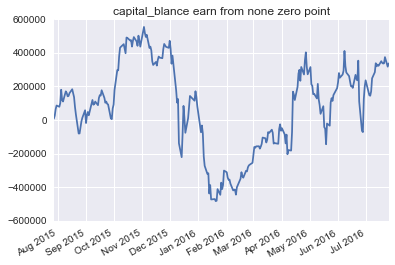

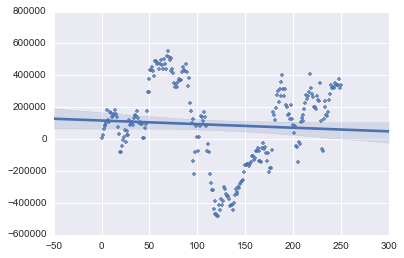

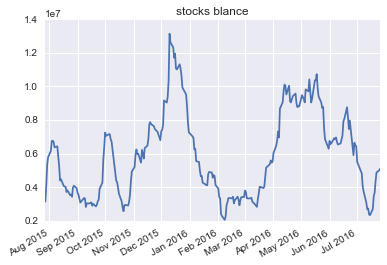

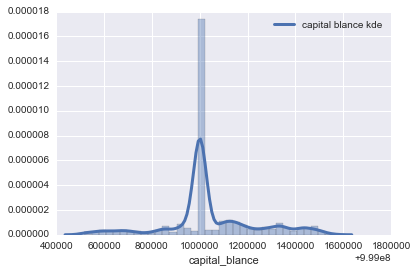

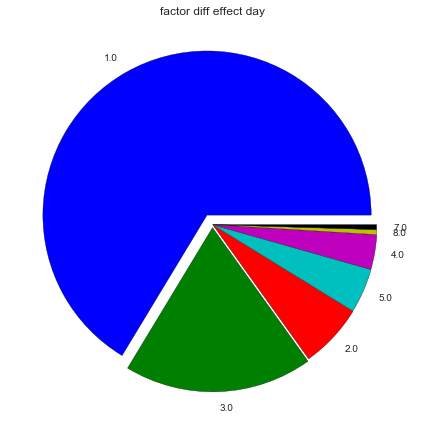

effect mean day: 1.7756097561


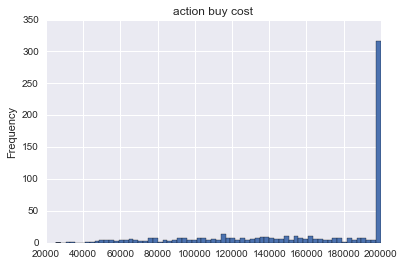

cost info: 
moments_tuple(mean=160508.95918926984, std=48188.23197058294, skewness=-0.912289200610963, kurtosis=2.5446141847946633)


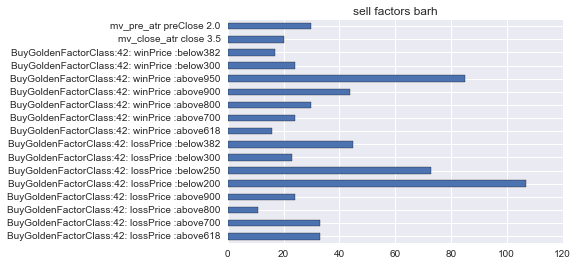

BuyGoldenFactorClass:42: lossPrice :above618     33.0
BuyGoldenFactorClass:42: lossPrice :above700     33.0
BuyGoldenFactorClass:42: lossPrice :above800     11.0
BuyGoldenFactorClass:42: lossPrice :above900     24.0
BuyGoldenFactorClass:42: lossPrice :below200    107.0
BuyGoldenFactorClass:42: lossPrice :below250     73.0
BuyGoldenFactorClass:42: lossPrice :below300     23.0
BuyGoldenFactorClass:42: lossPrice :below382     45.0
BuyGoldenFactorClass:42: winPrice :above618      16.0
BuyGoldenFactorClass:42: winPrice :above700      24.0
BuyGoldenFactorClass:42: winPrice :above800      30.0
BuyGoldenFactorClass:42: winPrice :above900      44.0
BuyGoldenFactorClass:42: winPrice :above950      85.0
BuyGoldenFactorClass:42: winPrice :below300      24.0
BuyGoldenFactorClass:42: winPrice :below382      17.0
mv_close_atr close 3.5                           20.0
mv_pre_atr preClose 2.0                          30.0
dtype: float64


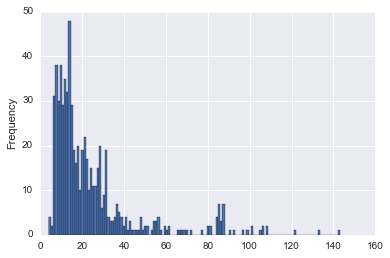

keep days mean: 20.7683881064
keep days median: buy Date            2.016011e+07
buy Price           1.900000e+01
buy Cnt             8.141000e+03
Sell Price          1.981000e+01
MaxLoss                     -inf
key                 3.680000e+02
profit             -1.447280e+03
result             -1.000000e+00
R                  -0.000000e+00
sharpe              8.675231e-01
profit_cg          -8.085820e-03
profit_cg_hunder   -8.085820e-01
keep_days           1.600000e+01
dtype: float64

factor win effect = 0.0266040688576%
factor loss effect = 0.0704225352113%


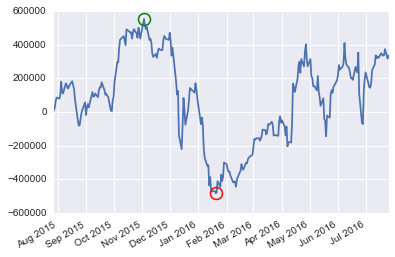

max down rate: 0.00103634217078
{(Timestamp('2015-11-03 00:00:00'), Timestamp('2016-01-20 00:00:00')): 1036916.7749999762}
factor effect symbol rate: 0.833333333333
factor gen order rate: 1.86388888889

R win rate: 0.0
result win rate: 0.44262295082
R return: 0.0
P return: 0.00344584490428
C return: 0.000336866372999
C PB:      -225.85736221

order win mean: 11201.3708081 cg: 8.4618709242
order win max: 52166.24 cg: 94.472361809

Win Top 5
2016-04-01    94.472362
2016-02-11    88.967972
2015-08-24    69.595769
2016-04-11    54.968944
2016-01-20    49.286968
Name: profit_cg_hunder, dtype: float64

order loss mean: -8843.96695906 cg: -6.7046379389
order loss max: -38703.86 cg: -42.3272913761

2016-04-27   -42.327291
2015-10-02   -34.682081
2015-12-21   -28.935877
2015-12-03   -27.548505
2016-01-07   -22.117647
Name: profit_cg_hunder, dtype: float64



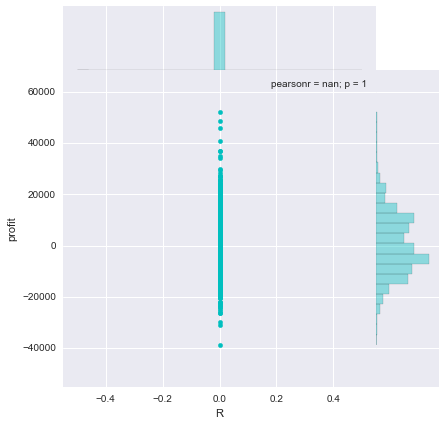

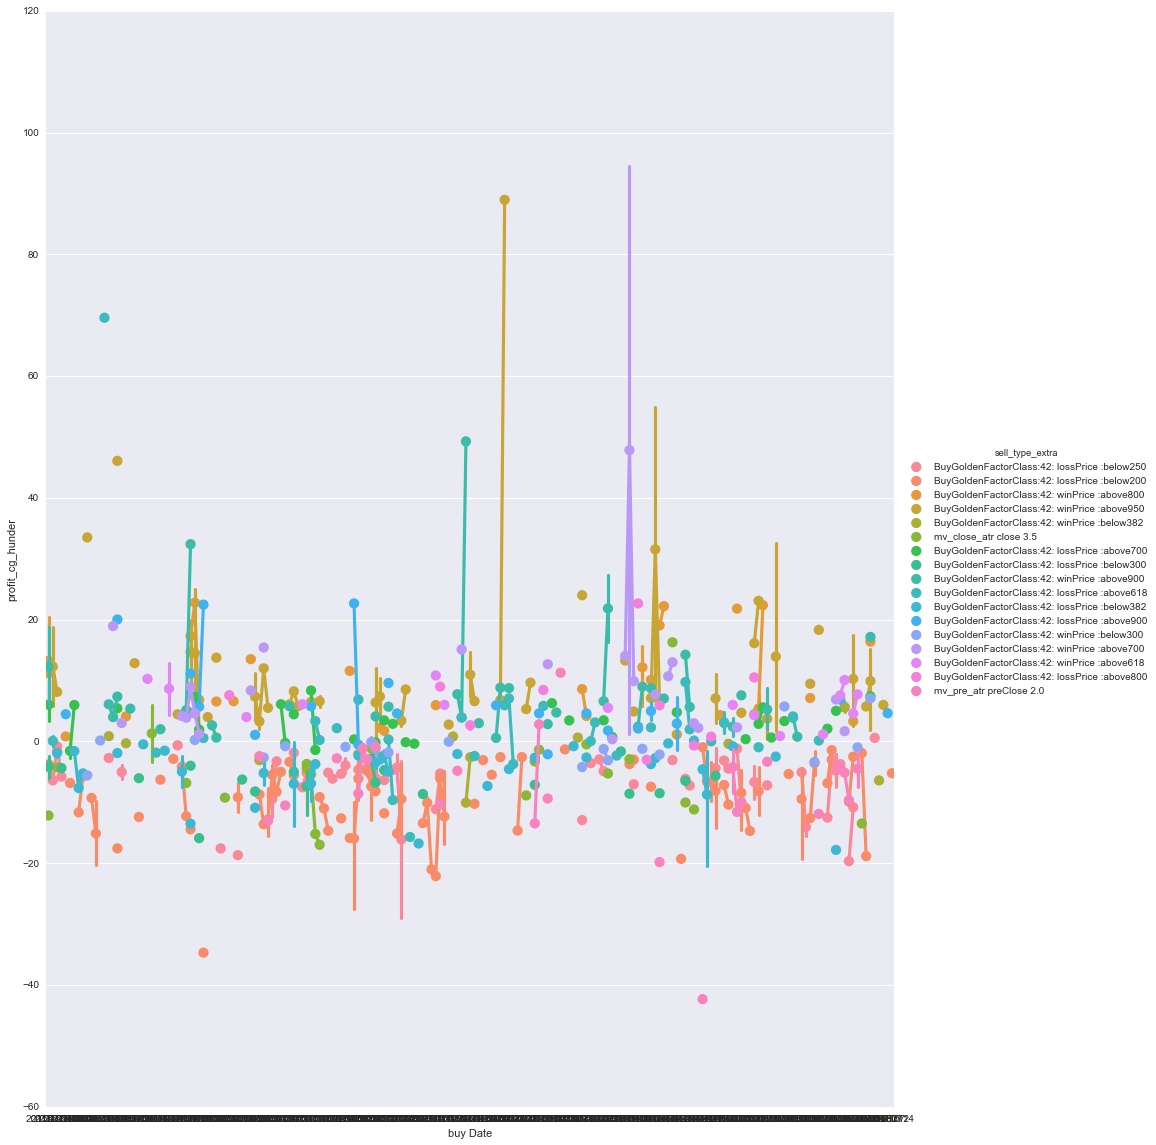

top 10 win profit_cg mean: 52.9291779451
top 10 loss profit_cg  mean: -25.6946617318


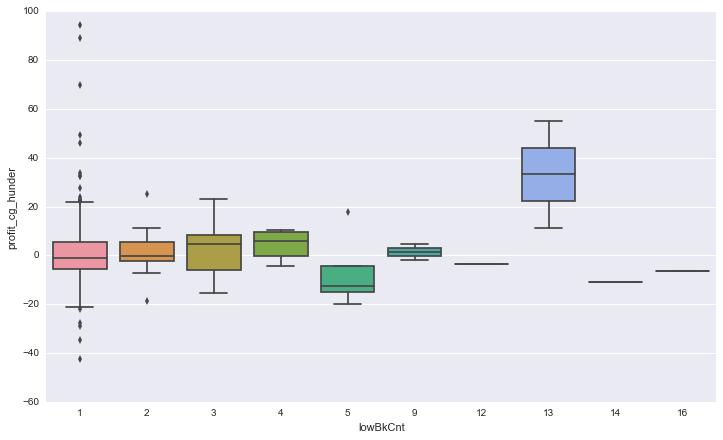

TOP 3 = [(1, 623), (2, 23), (3, 9)]


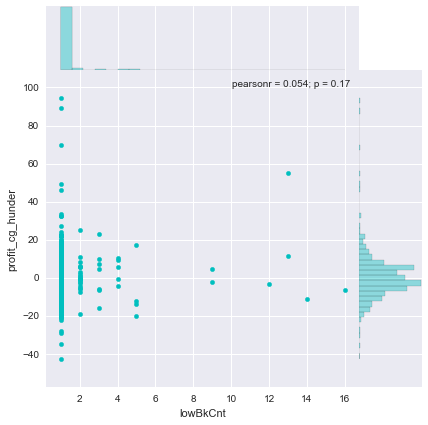

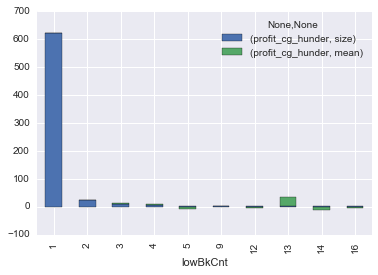

{'grid_scroe': defaultdict(list,
             {'max_down': [0.0010363421707753153],
              'return': [(0.0034458449042790063,
                0.0,
                0.00033686637299945588,
                -225.85736221036333)],
              'sc_efm': [-2.0],
              'sc_emd': [4.473684210526315],
              'sc_fwl': [0.1724137931034484],
              'sc_wl10m': [3.6842105263157894],
              'sc_wlm': [-2.6315789473684212]}),
 'score': 3.6987295825771316}

In [21]:
rsc = metrics_rsc(*(cap, results, orders_pd, action_pd, all_fit_symbols))
MetricsManger.make_metrics_from_rsc(rsc, METRICSTYPE.SYSMBOL_R_SCORES_GOLDEN.value)

更多度量相关请参考：[git地址](https://github.com/bbfamily/abu/blob/master/%E5%BA%A6%E9%87%8F%E5%B7%A5%E5%85%B7-ABU%E9%87%8F%E5%8C%96%E7%B3%BB%E7%BB%9F.ipynb)

铺垫将到这一章就差不多了，我能力有限，不能通过这么短的篇幅和内容把所有事情讲清楚，如有不明白加我微信一起探讨，从下一章开始
就是真正的‘印钞机’🔑之路了，直到这里为止，你只要知道大概能理解**‘非均衡胜负收益’带来的必然’非均衡胜负比例‘，目标由’因子‘的能力解决一部分**j就可以，至于具体的技术细节，暂时不用太在意，如果你能深入下去，这一切都不是事🎎

## 感谢🙏您能有耐心看到这里
## 如果有什么问题可以加阿布的微信 
## 微信号：aaaabbbuu

![image](./mmexport1475383814280.jpg)